In [90]:
from qiskit import QuantumCircuit
LABS_qc = QuantumCircuit().from_qasm_file('benchmark/MaxCut_Random/logical/Random5_7_logical_circuit.qasm')

import numpy as np
def cz_to_cnot(qc):
    new_qc = QuantumCircuit(len(qc.qubits), len(qc.clbits))
    for gate in qc.data:
        if gate.name == 'cz':
            new_qc.cx(*gate.qubits)
            new_qc.t(gate.qubits[1])
            new_qc.cx(*gate.qubits)
        else:
            new_qc.append(gate)
    return new_qc

def zz_to_cnot(qc):
    new_qc = QuantumCircuit(len(qc.qubits), len(qc.clbits))
    for gate in qc.data:
        if gate.name == 'rzz':
            new_qc.cz(*gate.qubits)
            # new_qc.cx(*gate.qubits)
            # new_qc.t(gate.qubits[1])
            # new_qc.cx(*gate.qubits)
        else:
            new_qc.append(gate)
    return new_qc

def zz_to_cnot_z(qc):
    new_qc = QuantumCircuit(len(qc.qubits), len(qc.clbits))
    for gate in qc.data:
        if gate.name == 'rzz':
            new_qc.cz(*gate.qubits)
        else:
            new_qc.append(gate)
    return new_qc

def cz_to_cnot_z(qc):
    new_qc = QuantumCircuit(len(qc.qubits), len(qc.clbits))
    for gate in qc.data:
        if gate.name == 'cz':
            new_qc.cz(*gate.qubits)
        else:
            new_qc.append(gate)
    return new_qc

cnot_LABS_qc = zz_to_cnot(LABS_qc)
cnot_z_LABS_qc = zz_to_cnot_z(LABS_qc)

In [91]:
with open('benchmark/MaxCut_Random/layout_melbourne/Random8_10_OLSQ_layout.txt', 'r') as f:
    physical_node = [line.strip() for line in f]

import json
with open('/Users/xinpengli/Desktop/OptimalPhasePoly/coupling_maps/melbourne.json', 'r') as f:
    device_topol = json.load(f)

physical_node = [int(i) for i in physical_node]

physical_layout = []
for a,b in device_topol:
    if a in physical_node and b in physical_node:
        physical_layout.append((a,b))

from src.util import coupling_map_physical_index_to_logical_index, get_subcoupling_map
logical_subsubcoupling_map = coupling_map_physical_index_to_logical_index(get_subcoupling_map(device_topol, physical_node), physical_node)

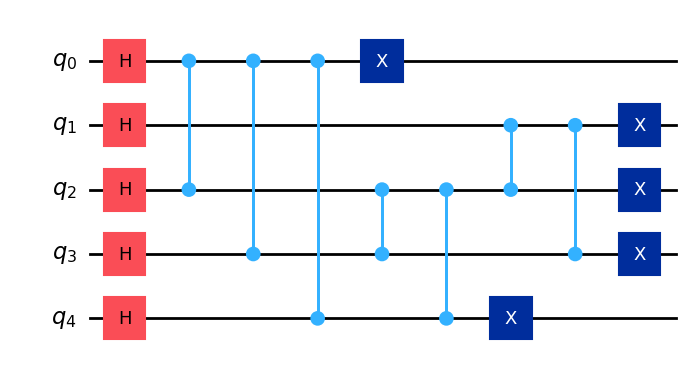

In [92]:
cnot_LABS_qc.draw()

In [93]:
from qiskit import qasm2, qasm3
from olsq2.device import qcdevice, get_device_by_name
from olsq2 import OLSQ
import time

qlc_solver = OLSQ("depth", "normal",encoding=1)
coupling_map = logical_subsubcoupling_map 
num_physical_qubit = max(max(edge) for edge in coupling_map)+1
# directly construct a device from properties needed by olsq
qlc_solver.setdevice( qcdevice(name="dev", nqubits=num_physical_qubit, 
    connection=coupling_map, swap_duration=3))

olsq_input_circuit = cnot_LABS_qc

circuit_file = qasm3.dumps(olsq_input_circuit)
start_time = time.time()
qlc_solver.setprogram(circuit_file)
result = qlc_solver.solve(use_sabre=False)
end_time = time.time()

olsq_qc = QuantumCircuit.from_qasm_str(result[0])
# cnot_olsq_qc = zz_to_cnot(olsq_qc)

Using normal mode...
Run heuristic compiler sabre to get upper bound for SWAP: 2, depth: 11
start adding constraints...
Trying maximal depth = 8...
status:unsat, Depth optimization time = 0:00:00.143419, time including preprocessing = 2.5152802920001704
FAIL to find solution with depth less than  8.
(:max-memory              174.49
 :memory                  28.58
 :num-allocs              1183727838525.00
 :rlimit-count            261966620
 :sat-backjumps           290
 :sat-conflicts           291
 :sat-decisions           974
 :sat-del-clause          19044
 :sat-elim-bool-vars-res  6971
 :sat-elim-clauses        1277
 :sat-elim-literals       814
 :sat-minimized-lits      659
 :sat-mk-clause-2ary      44142
 :sat-mk-clause-3ary      10345
 :sat-mk-clause-nary      23161
 :sat-mk-var              12191
 :sat-propagations-2ary   495525
 :sat-propagations-nary   105272
 :sat-restarts            25
 :sat-scc-elim-binary     18
 :sat-scc-elim-vars       137
 :sat-subs-resolution     396

In [94]:
cnot_olsq_qc = cz_to_cnot(olsq_qc)
from src.util import strip_circuit

print(strip_circuit(cnot_olsq_qc).depth())
print(cnot_olsq_qc.count_ops()['cx'])

13
20


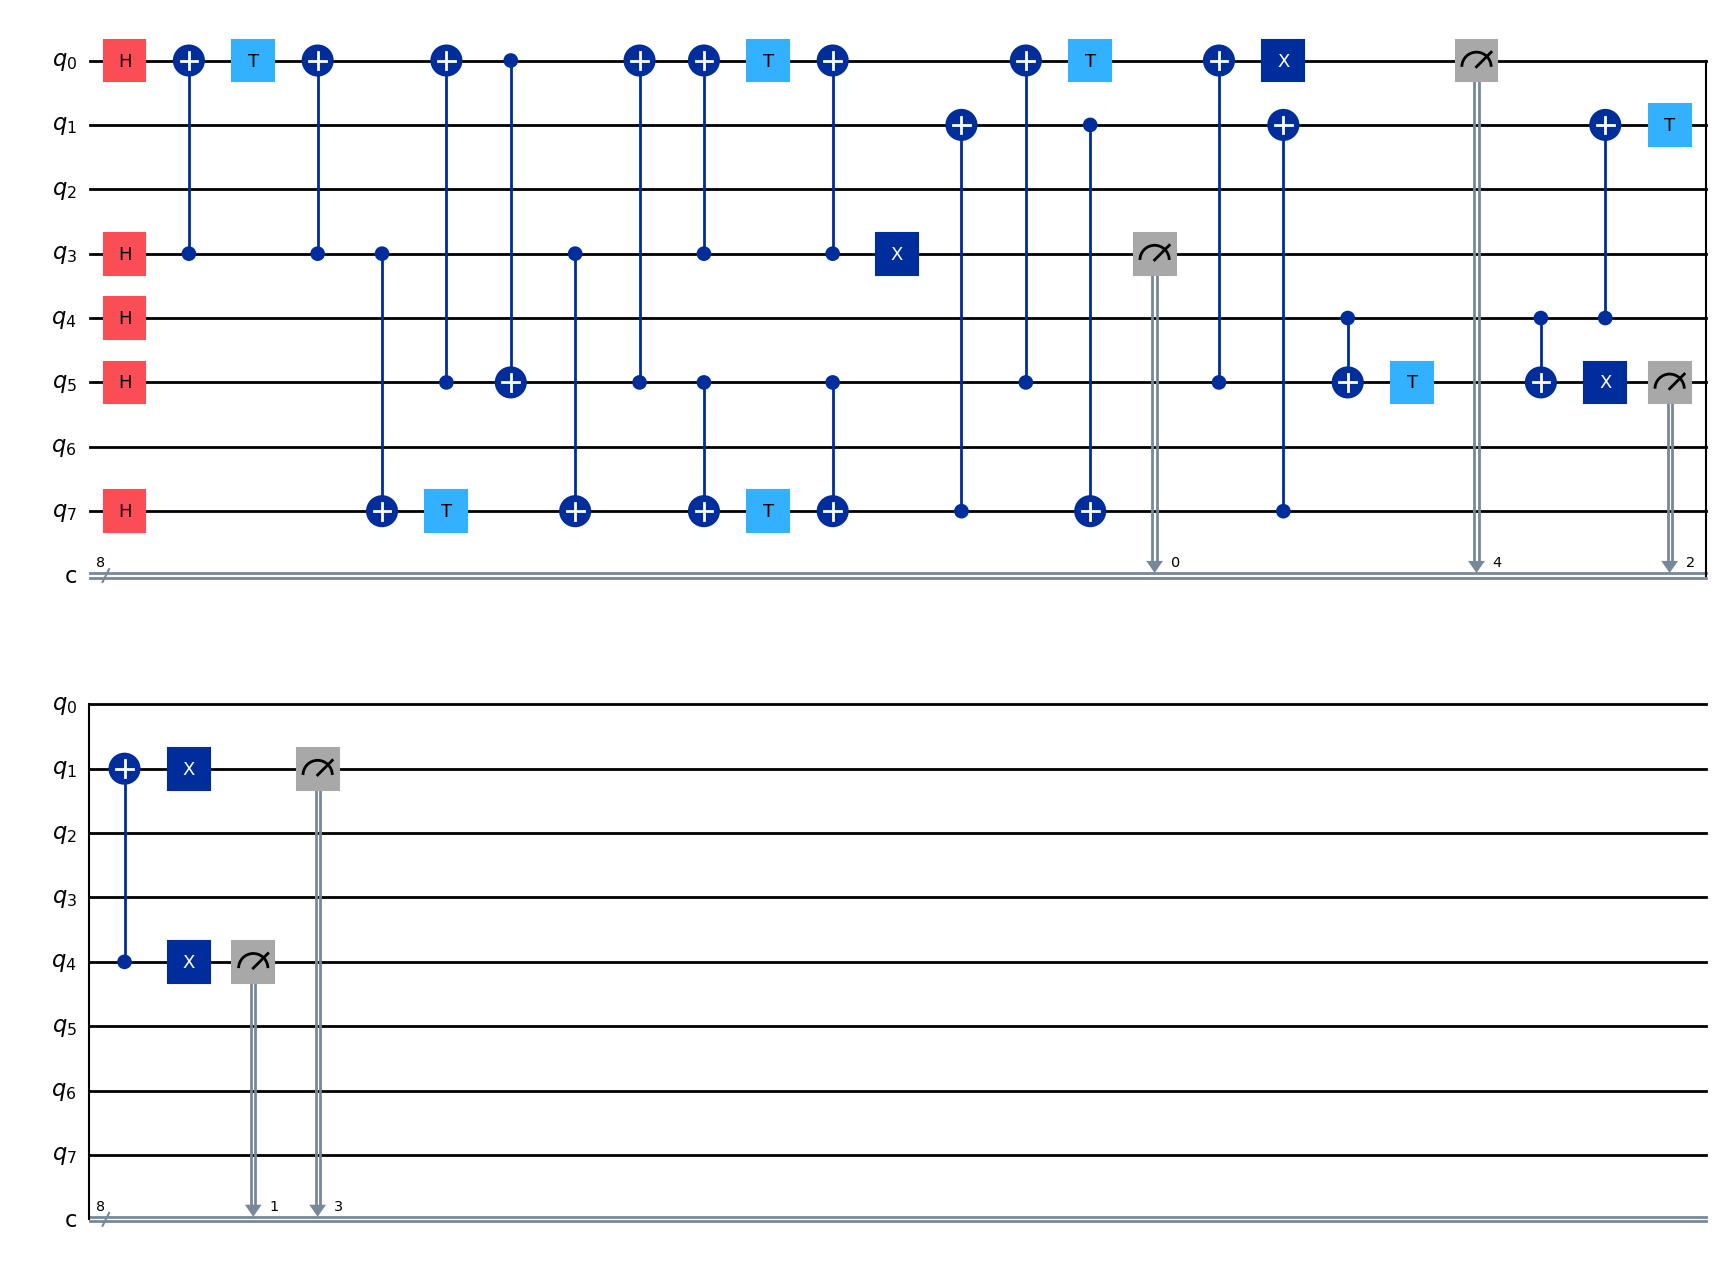

In [95]:
cnot_olsq_qc.draw()

In [96]:
from src.blockwise_opt import block_opt_general

opt_cnotp_qc = block_opt_general(cnot_olsq_qc, coupling_map, method = 'cnot')

In [97]:
print(opt_cnotp_qc.count_ops()['cx'])
print(strip_circuit(opt_cnotp_qc).depth())

20
14
